# Watershed

Ce notebook lis la carte de prédiction pixel-wise et chercher à determiner les objets dans chaque classes. La pipeline est:
- morpho
- watershed
- rag de régions
- merge des régions

---

# Chargement

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from src.utils import *
from collections import Counter
from skimage.morphology import remove_small_objects, remove_small_holes, binary_closing, disk, closing
from skimage import measure
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.color import label2rgb
from scipy import ndimage as ndi
from skimage import graph
from skimage.measure import label

On charge la carte de prédiction.

In [2]:
prediction = np.load("output/classification.npy")

On charge la zone.

In [22]:
def load_patch():
    x = 4500
    y = 1600
    width = 1000
    height = 1000
    
    files = ["BSE", "Fe", "S", "O", "Mg", "Ca", "Al", "Si"]
    images = load_images(x, y, width, height, files)
    
    features = [
        "BSE", "Ca", "Al", "Mg", "Si", "Fe", "S", "O",
        #"g Ca", "g Al",
        #"g BSE",
        #"g Mg", "g Si", "g Fe", "g S", "g O",
        #"= Mg / (Mg + Fe + Ca + 0.0000001)", "= Mg / (Si + + 0.0000001)", "= Mg / (Fe + + 0.0000001)","= Ca / (Al + 0.0000001)", "= Fe / (Si + + 0.0000001)"
    ]
    
    return compute_features(images, features)

data = load_patch()
print(data.shape)

(1000, 1000, 8)


Ici on se concentre sur les chondre de type I pour construire la pipeline.

Les chondre de type I correspondent à 2 classes chondre type I et mesostase type I.

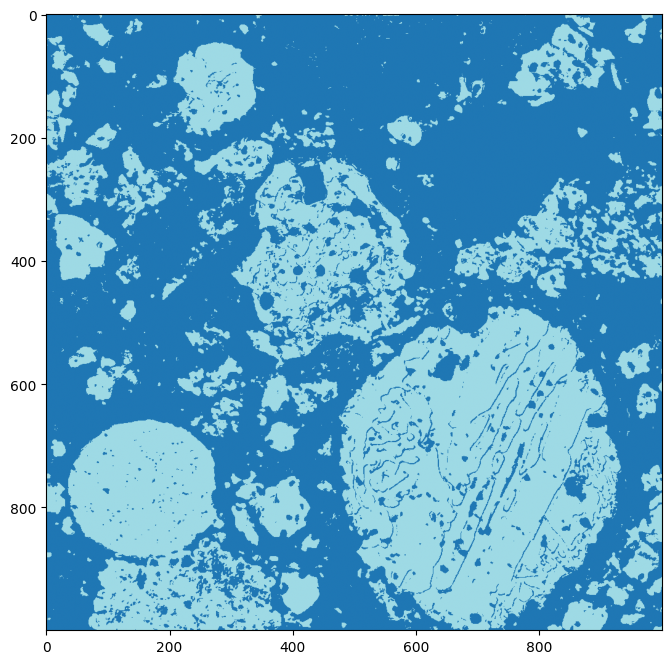

In [23]:
typeI = ((prediction == 0) | (prediction == 3))[0:1000,0:1000]

plot_single(typeI, "", cmap="tab20")

---

# Pipeline

On commence par faire un peu de morpho pour nettoyer les données:
- supprimer les petits objets (les pixels isolés, bruits de classification, des bouts de chondres coupés, etc)
- boucher les petits trous (bruits de classification, autre phases à l'intérieur, etc)
- fusionner les formes proches (pour reconstruire les chondres qui ont explosées)

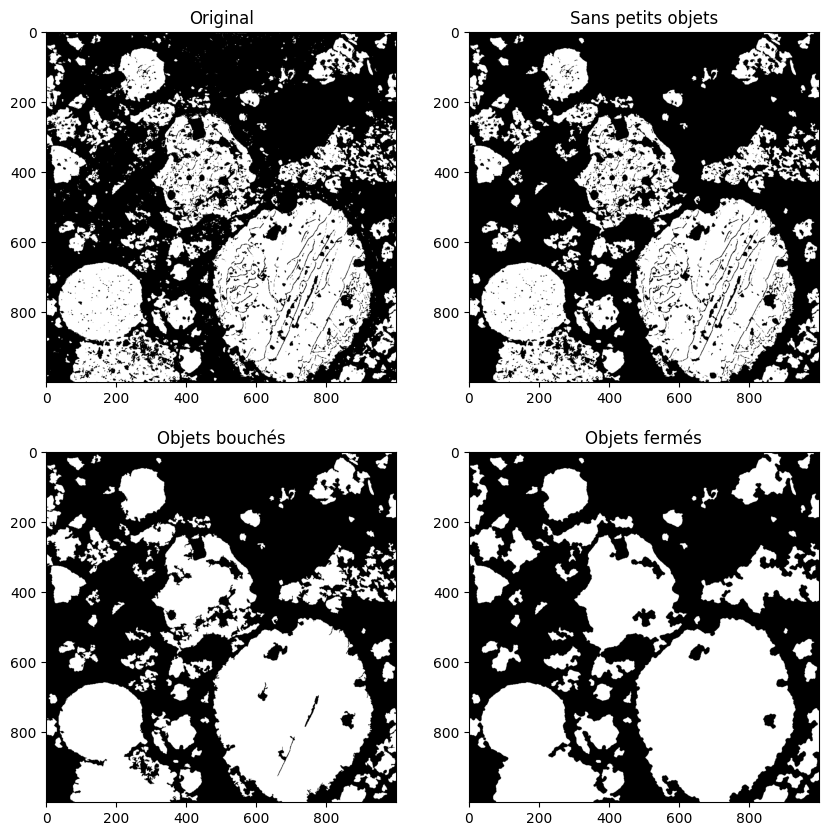

In [24]:
def cleanup(img):
    cleaned = remove_small_objects(typeI.astype(bool), min_size=100)
    filled = remove_small_holes(cleaned, area_threshold=500)
    closed = closing(filled, disk(4))
    closed = remove_small_holes(closed, area_threshold=1000)
    
    plt.figure(figsize=(10, 10))
    
    plt.subplot(2, 2, 1)
    plt.imshow(typeI, cmap="gray")
    plt.title("Original")
    
    plt.subplot(2, 2, 2)
    plt.imshow(cleaned, cmap="gray")
    plt.title("Sans petits objets")
    
    plt.subplot(2, 2, 3)
    plt.imshow(filled, cmap="gray")
    plt.title("Objets bouchés")

    plt.subplot(2, 2, 4)
    plt.imshow(closed, cmap="gray")
    plt.title("Objets fermés")

    plt.show()

    return filled, closed

typeI_filled, typeI_cleaned = cleanup(typeI)

Maintenant on fait un watershed pour découper les chondres qui se touche.

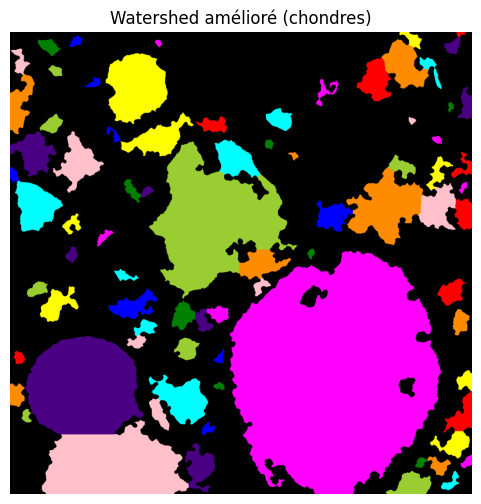

In [77]:
from scipy.ndimage import gaussian_filter
from skimage.morphology import h_maxima

def apply_watershed_smart(img):
    distance = ndi.distance_transform_edt(img)
    distance = gaussian_filter(distance, sigma=4)

    markers = h_maxima(distance, h=2)
    markers = measure.label(markers)

    labels_ws = watershed(-distance, markers, mask=img)

    plt.figure(figsize=(6,6))
    plt.imshow(label2rgb(labels_ws, bg_label=0))
    plt.title("Watershed amélioré (chondres)")
    plt.axis('off')
    plt.show()

    return labels_ws

typeI_watershed = apply_watershed_smart(typeI_cleaned)

Maintenant l'idée c'est de fusionner les zones. Donc on considère un graphe ou chaque noeud est une région et chaque arrête les régions voisines. On attribue à chaque noeud une valeur qui correspond à un vecteur:
- avec la moyenne et la variance sur la région des cartes EDS + BSE

Ensuite chaque arrête à un poid qui correspond à la différence entre deux noeuds.

L'algo itère sur le graphe et merge deux régions/noeuds lorsque l'arrête qui les sépares à une petite valeur, on recalcul ensuite la moyenne sur ce nouveau noeuds et ainsi de suite jusqu'a ce qu'on ne puisse plus fusionner.

In [78]:
def compute_region_features(image, segments):
    features = {}
    for seg_id in np.unique(segments):
        mask = (segments == seg_id)
        if np.any(mask):
            data = image[mask]
            features[seg_id] = {
                'mean': data.mean(axis=0),
                'var': data.var(axis=0)
            }

    return features

def spectral_angle(v1, v2):
    cos_angle = np.clip(np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)),-1,1)
    return np.arccos(cos_angle)

def region_distance(fea1, fea2, alpha=1.0, beta=0.0001):
    beta = 0
    d_mean = spectral_angle(fea1['mean'], fea2['mean'])
    d_var = np.linalg.norm(fea1['var'] - fea2['var'])
    return alpha*d_mean + beta*d_var

def merge_objects(tensor_crop, segments, tau=0.01):
    merged = segments.copy()
    current_features = compute_region_features(tensor_crop, merged)

    while True:
        rag = graph.RAG(merged)
        best = None
        best_w = np.inf

        for n1, n2 in rag.edges():
            w = region_distance(current_features[n1], current_features[n2])
            if w < best_w:
                best_w = w
                best = (n1, n2)

        if best is None or best_w > tau:
            break

        n1, n2 = best
        merged[merged == n2] = n1

        mask = (merged == n1)
        data = tensor_crop[mask]
        current_features[n1] = {
            'mean': data.mean(axis=0),
            'var': data.var(axis=0)
        }

        del current_features[n2]

    return merged

On execute l'algo:

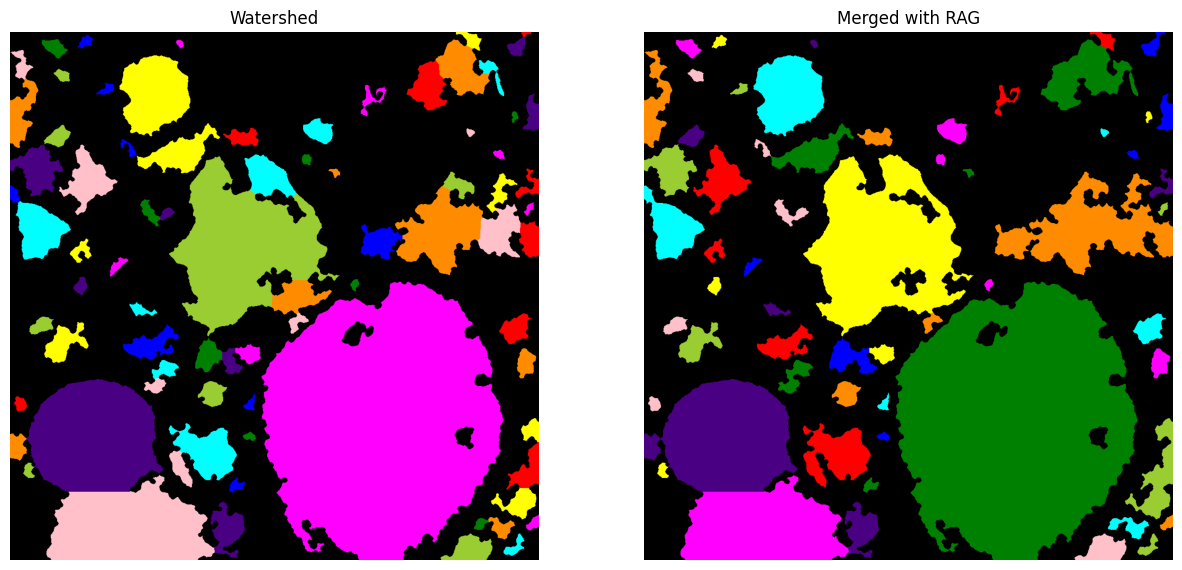

In [79]:
def pipeline(tensor_crop, typeI_watershed): 
    segments_merged = merge_objects(tensor_crop, typeI_watershed, tau=0.15)

    labeled_objects = label(segments_merged)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    colored = label2rgb(labeled_objects, bg_label=0)

    ax[0].imshow(label2rgb(typeI_watershed, bg_label=0))
    ax[0].axis('off')
    ax[0].set_title("Watershed")
    
    ax[1].imshow(colored)
    ax[1].axis('off')
    ax[1].set_title("Merged with RAG")

    plt.show()

    return labeled_objects, colored


object_prediction, object_colored = pipeline(data, typeI_watershed)

On compare avec la carte BSE pour avoir une petite idée du résultat:

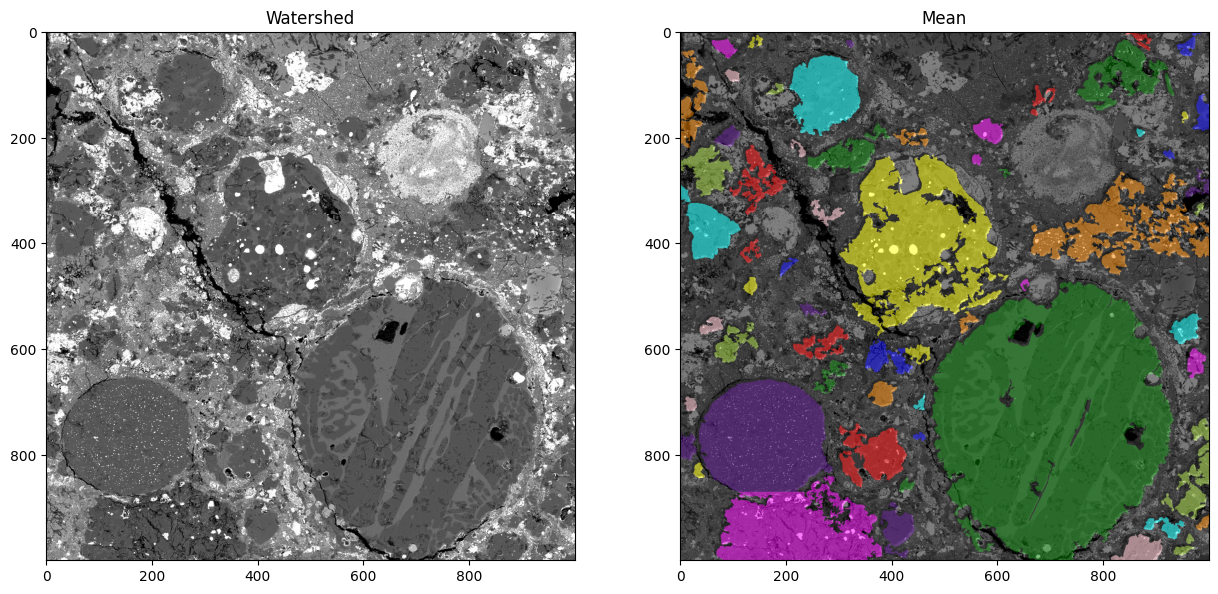

In [81]:
bse_crop = data[:,:,0]

mask_3c = np.stack([typeI_filled]*3, axis=-1)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].imshow(bse_crop, cmap="grey")
ax[0].set_title("Watershed")

ax[1].imshow(bse_crop, cmap='gray')
ax[1].imshow(object_colored * mask_3c, alpha=0.5)  
ax[1].set_title("Mean")

plt.show()

In [82]:
np.save("output/object_prediction.npy", object_prediction)